In [1]:
from direct_effect_analysis import DirectEffectAnalysis, MANCOVA
from utils import *
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import pearsonr
from pywhy_stats import independence_test, fisherz
import pywhy_stats as ps
from generalised_covariance_measure import GCM_translation
from collections import defaultdict
import seaborn as sns
from pywhy_stats.independence import kci, fisherz
from pgmpy.estimators import PC
import scipy
from plotnine import ggplot, aes, geom_tile, geom_text, scale_fill_gradient, labs, facet_wrap, theme, element_text, ggsave, scale_fill_cmap
from scipy.stats import norm
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA, KernelPCA

In [2]:
def parameters(r, p, q, d, H_0=True):
    beta = np.random.uniform(-1, 1, (r, p))
    beta = beta/np.linalg.norm(beta)
    gamma = np.random.uniform(-1, 1, (p, q))
    gamma = gamma/np.linalg.norm(gamma)
    A_x, A_z = np.ones((q, d)), np.random.uniform(-1, 1, (r, d))
    A_z = A_z/np.linalg.norm(A_z)
    if H_0 :
        A_x = np.random.uniform(0, 0, (q, d))
    return A_x, A_z, beta, gamma

In [3]:
def compute_pvalue_T_D(T, dfn1, dfd1, dfn2, dfd2, n_samples=10000):
    samples_1 = f.rvs(dfn1, dfd1, size=n_samples)
    samples_2 = f.rvs(dfn2, dfd2, size=n_samples)
    diff_samples = samples_2 - samples_1 
    p_value = np.mean(diff_samples >= T)
    return p_value

In [4]:
rk, r, p, q = 10, 1, 1, 1
samples = [100, 200, 500]
dimensions = [2, 5, 10, 20, 50]
B = 100
noise = 'diag'
ap, bp, cp = 0.2, 0.2, 0.6
a, b, c = 0.1, 0.1, 0.8

In [5]:


results = {
    'T_F-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'T_F-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'T_D-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'T_D-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))]
}


i = 0
for  d in tqdm(dimensions):
    for n_index, N in enumerate(samples):
        for b in range(B):
            A_x, A_z, beta, gamma = parameters(r, p, q, d, False)
            X_train, Y_train, Z_train, Y_x_train = generate_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=10, a=a, b=b, c=c)
            # T_F test
            dea = DirectEffectAnalysis(type='T_F', alpha=1e-5)
            # df1, df2 = result['Num DF'], result['Den DF']
            df1 = d
            df2 = N - p - r - d - 1
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results['T_F-stat'][i][n_index][b].append(F)
            results['T_F-pval'][i][n_index][b].append(pval)

            # T_D test
            dea = DirectEffectAnalysis(type='T_D', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F =  np.abs((df2 / df1) * np.abs(dea.u[0]))
            pval = f.sf(F, df1, df2)
            results['T_D-stat'][i][n_index][b].append(F)
            results['T_D-pval'][i][n_index][b].append(pval)

            # CCA
            dea = DirectEffectAnalysis(type='pCCA', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results['CCA-stat'][i][n_index][b].append(F)
            results['CCA-pval'][i][n_index][b].append(pval)

            # GCM test
            stat_gcm, pval_gcm = GCM_translation(X_train, Y_train, Z_train)
            results['GCM-stat'][i][n_index][b].append(stat_gcm)
            results['GCM-pval'][i][n_index][b].append(pval_gcm)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='FISHERZ')
            pval, stat = result.pvalue, result.statistic
            results['F-stat'][i][n_index][b].append(stat)
            results['F-pval'][i][n_index][b].append(pval)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='KCI')
            pval, stat = result.pvalue, result.statistic
            results['KCI-stat'][i][n_index][b].append(stat)
            results['KCI-pval'][i][n_index][b].append(pval)
    i += 1

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [10:34<00:00, 126.83s/it]


/tmp/ipykernel_5143/1080418892.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


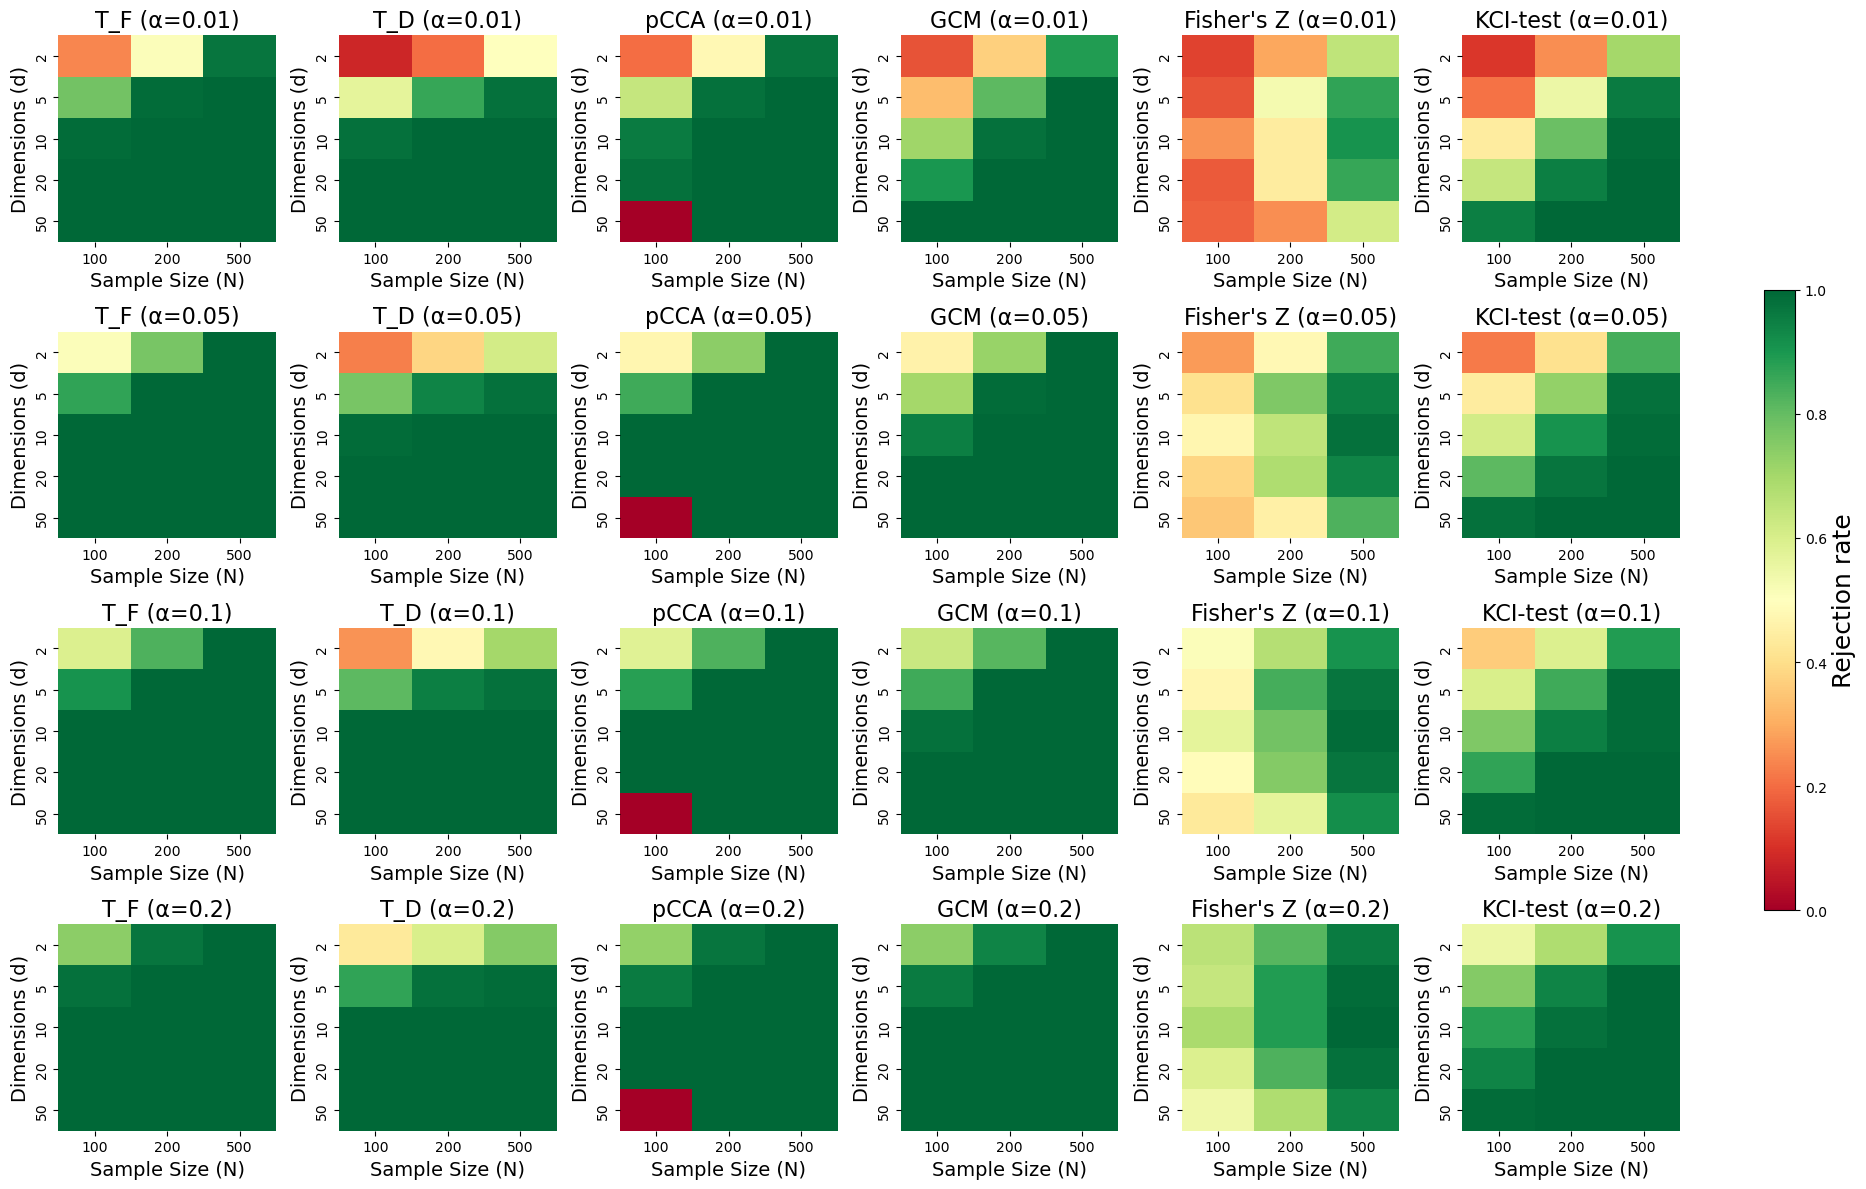

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_heatmap(data, ax, title, vmin, vmax, alpha, std_dev, significance_level=0.05, font_size=14, label_font_size=16):
    # Prepare annotations with stars for significant cells
    annotations = np.empty_like(data, dtype=object)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Calculate Z-score and p-value for the current cell
            z_score = (data[i, j] - alpha) / std_dev
            p_val_z = 1 - norm.cdf(z_score)  # Upper-tail test
            
            # If p-value is below the significance threshold, add a star
            if p_val_z < significance_level:
                annotations[i, j] = f'{data[i, j]:.2f} *'
            else:
                annotations[i, j] = f'{data[i, j]:.2f}'
    
    # Plot the heatmap with the custom annotations
    sns.heatmap(data, fmt="", cmap="RdYlGn", ax=ax, 
                xticklabels=[str(n) for n in samples], 
                yticklabels=[str(d) for d in dimensions],
                cbar=False, vmin=vmin, vmax=vmax,
                annot_kws={"size": font_size})
    
    ax.set_title(title, fontsize=label_font_size+2)
    ax.set_xlabel('Sample Size (N)', fontsize=label_font_size)
    ax.set_ylabel('Dimensions (d)', fontsize=label_font_size)

# Different alpha values
alphas = [0.01, 0.05, 0.1, 0.2]
std_dev = 0.01  # Assuming Gaussian standard deviation for simplicity

# Set up the 4x4 grid of subplots
fig, axes = plt.subplots(len(alphas), 6, figsize=(20, 12))

# Loop through each alpha and create corresponding row of heatmaps
for row, alpha in enumerate(alphas):
    mean_pvals = {
        'T_F': (np.array(results['T_F-pval']) < alpha).mean(axis=2)[:, :, 0],
        'T_D': (np.array(results['T_D-pval']) < alpha).mean(axis=2)[:, :, 0],
        'pCCA': (np.array(results['CCA-pval']) < alpha).mean(axis=2)[:, :, 0],
        'GCM': (np.array(results['GCM-pval']) < alpha).mean(axis=2)[:, :, 0],
        'Fisher\'s Z': (np.array(results['F-pval']) < alpha).mean(axis=2)[:, :, 0],
        'KCI-test': (np.array(results['KCI-pval']) < alpha).mean(axis=2)[:, :, 0]
    }

    # Find common vmin and vmax for all heatmaps at this alpha
    vmin = 0
    vmax = 1
    # Create heatmaps for each method (GEV, GCM, F-test, KCI-test)
    for col, (method, data) in enumerate(mean_pvals.items()):
        plot_heatmap(data, axes[row, col], f'{method} (α={alpha})', vmin, vmax, alpha, std_dev, font_size=12, label_font_size=14)

# Create a single color bar on the right side of the heatmaps
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm), ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Rejection rate', fontsize=18)  # Set larger font for the colorbar label

# Adjust layout to create space for the color bar
plt.subplots_adjust(right=0.85)  # Adjust right space for the color bar
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Fine-tune layout to fit everything

plt.show()


/tmp/ipykernel_5143/1212148480.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


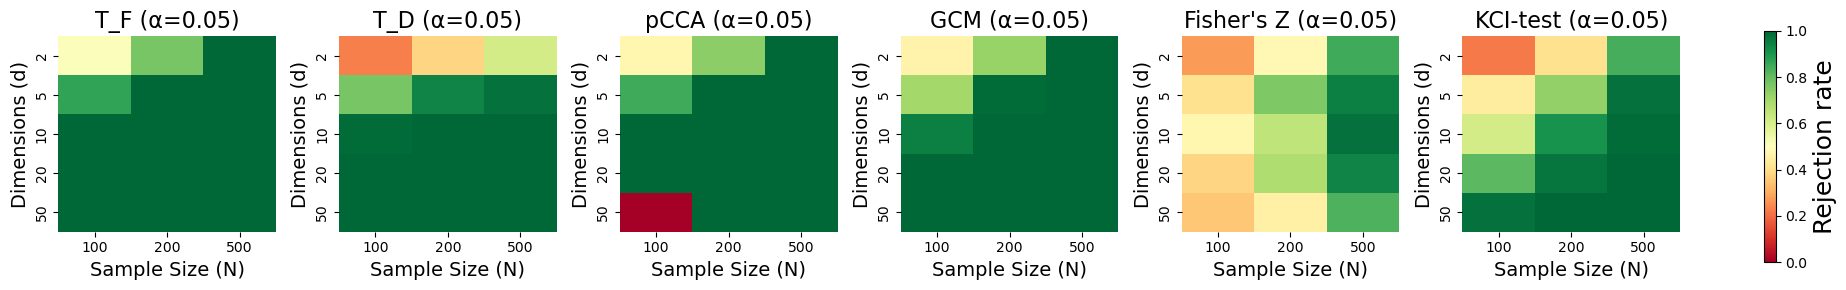

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_heatmap(data, ax, title, vmin, vmax, alpha, std_dev, significance_level=0.05, font_size=14, label_font_size=16):
    # Prepare annotations with stars for significant cells
    annotations = np.empty_like(data, dtype=object)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Calculate Z-score and p-value for the current cell
            z_score = (data[i, j] - alpha) / std_dev
            p_val_z = 1 - norm.cdf(z_score)  # Upper-tail test
            
            # If p-value is below the significance threshold, add a star
            if p_val_z < significance_level:
                annotations[i, j] = f'{data[i, j]:.2f} *'
            else:
                annotations[i, j] = f'{data[i, j]:.2f}'
    
    # Plot the heatmap with the custom annotations
    sns.heatmap(data, fmt="", cmap="RdYlGn", ax=ax, 
                xticklabels=[str(n) for n in samples], 
                yticklabels=[str(d) for d in dimensions],
                cbar=False, vmin=vmin, vmax=vmax,
                annot_kws={"size": font_size})
    
    ax.set_title(title, fontsize=label_font_size+2)
    ax.set_xlabel('Sample Size (N)', fontsize=label_font_size)
    ax.set_ylabel('Dimensions (d)', fontsize=label_font_size)

# Set alpha to 0.05 and standard deviation for Gaussian assumption
alpha = 0.05
std_dev = 0.01

# Create the figure with a single row for the heatmaps
fig, axes = plt.subplots(1, 6, figsize=(20, 3))

# Extract the mean p-values for alpha = 0.05 for each method
mean_pvals = {
    'T_F': (np.array(results['T_F-pval']) < alpha).mean(axis=2)[:, :, 0],
    'T_D': (np.array(results['T_D-pval']) < alpha).mean(axis=2)[:, :, 0],
    'pCCA': (np.array(results['CCA-pval']) < alpha).mean(axis=2)[:, :, 0],
    'GCM': (np.array(results['GCM-pval']) < alpha).mean(axis=2)[:, :, 0],
    'Fisher\'s Z': (np.array(results['F-pval']) < alpha).mean(axis=2)[:, :, 0],
    'KCI-test': (np.array(results['KCI-pval']) < alpha).mean(axis=2)[:, :, 0]
}

# Set the common vmin and vmax for the color scaling
vmin = 0
vmax = 1

# Plot heatmaps for each method
for col, (method, data) in enumerate(mean_pvals.items()):
    plot_heatmap(data, axes[col], f'{method} (α={alpha})', vmin, vmax, alpha, std_dev, font_size=12, label_font_size=14)

# Create a color bar for the heatmaps
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm), ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Rejection rate', fontsize=18)
50
# Adjust layout
plt.subplots_adjust(right=0.85)  # Adjust right space for the color bar
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Fine-tune layout to fit everything

plt.show()


In [8]:
results_H1 = {
    'T_D-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'T_D-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'T_F-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'T_F-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'CCA-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'OD-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'GCM-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'F-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-stat': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))],
    'KCI-pval': [[[[] for _ in range(B)] for _ in range(len(samples))] for _ in range(len(dimensions))]
}


i = 0
for  d in tqdm(dimensions):
    for n_index, N in enumerate(samples):
        for b in range(B):
            A_x, A_z, beta, gamma = parameters(r, p, q, d, True)
            X_train, Y_train, Z_train, Y_x_train = generate_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=10, a=a, b=b, c=c)
            df1 = d
            df2 = N - p - r - d - 1
            # T_D
            dea = DirectEffectAnalysis(type='T_D', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results_H1['T_D-stat'][i][n_index][b].append(F)
            results_H1['T_D-pval'][i][n_index][b].append(pval)

            # T_F
            df1 = d
            df2 = N - p - r - d - 1
            dea = DirectEffectAnalysis(type='T_F', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results_H1['T_F-stat'][i][n_index][b].append(F)
            results_H1['T_F-pval'][i][n_index][b].append(pval)

            # CCA
            df1 = d
            df2 = N - p - r - d - 1
            dea = DirectEffectAnalysis(type='pCCA', alpha=1e-5)
            dea.fit(X_train, Y_train, Z_train)
            F = np.abs((df2 / df1) * dea.u[0])
            pval = f.sf(F, df1, df2)
            results_H1['CCA-stat'][i][n_index][b].append(F)
            results_H1['CCA-pval'][i][n_index][b].append(pval)
            
            # GCM test
            stat_gcm, pval_gcm = GCM_translation(X_train, Y_train, Z_train)
            results_H1['GCM-stat'][i][n_index][b].append(stat_gcm)
            results_H1['GCM-pval'][i][n_index][b].append(pval_gcm)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='FISHERZ')
            pval, stat = result.pvalue, result.statistic
            results_H1['F-stat'][i][n_index][b].append(stat)
            results_H1['F-pval'][i][n_index][b].append(pval)

            # F test
            result = independence_test(X_train, Y_train, condition_on=Z_train, method='KCI')
            pval, stat = result.pvalue, result.statistic
            results_H1['KCI-stat'][i][n_index][b].append(stat)
            results_H1['KCI-pval'][i][n_index][b].append(pval)
    i += 1

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [11:02<00:00, 132.51s/it]


/tmp/ipykernel_5143/2039307116.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


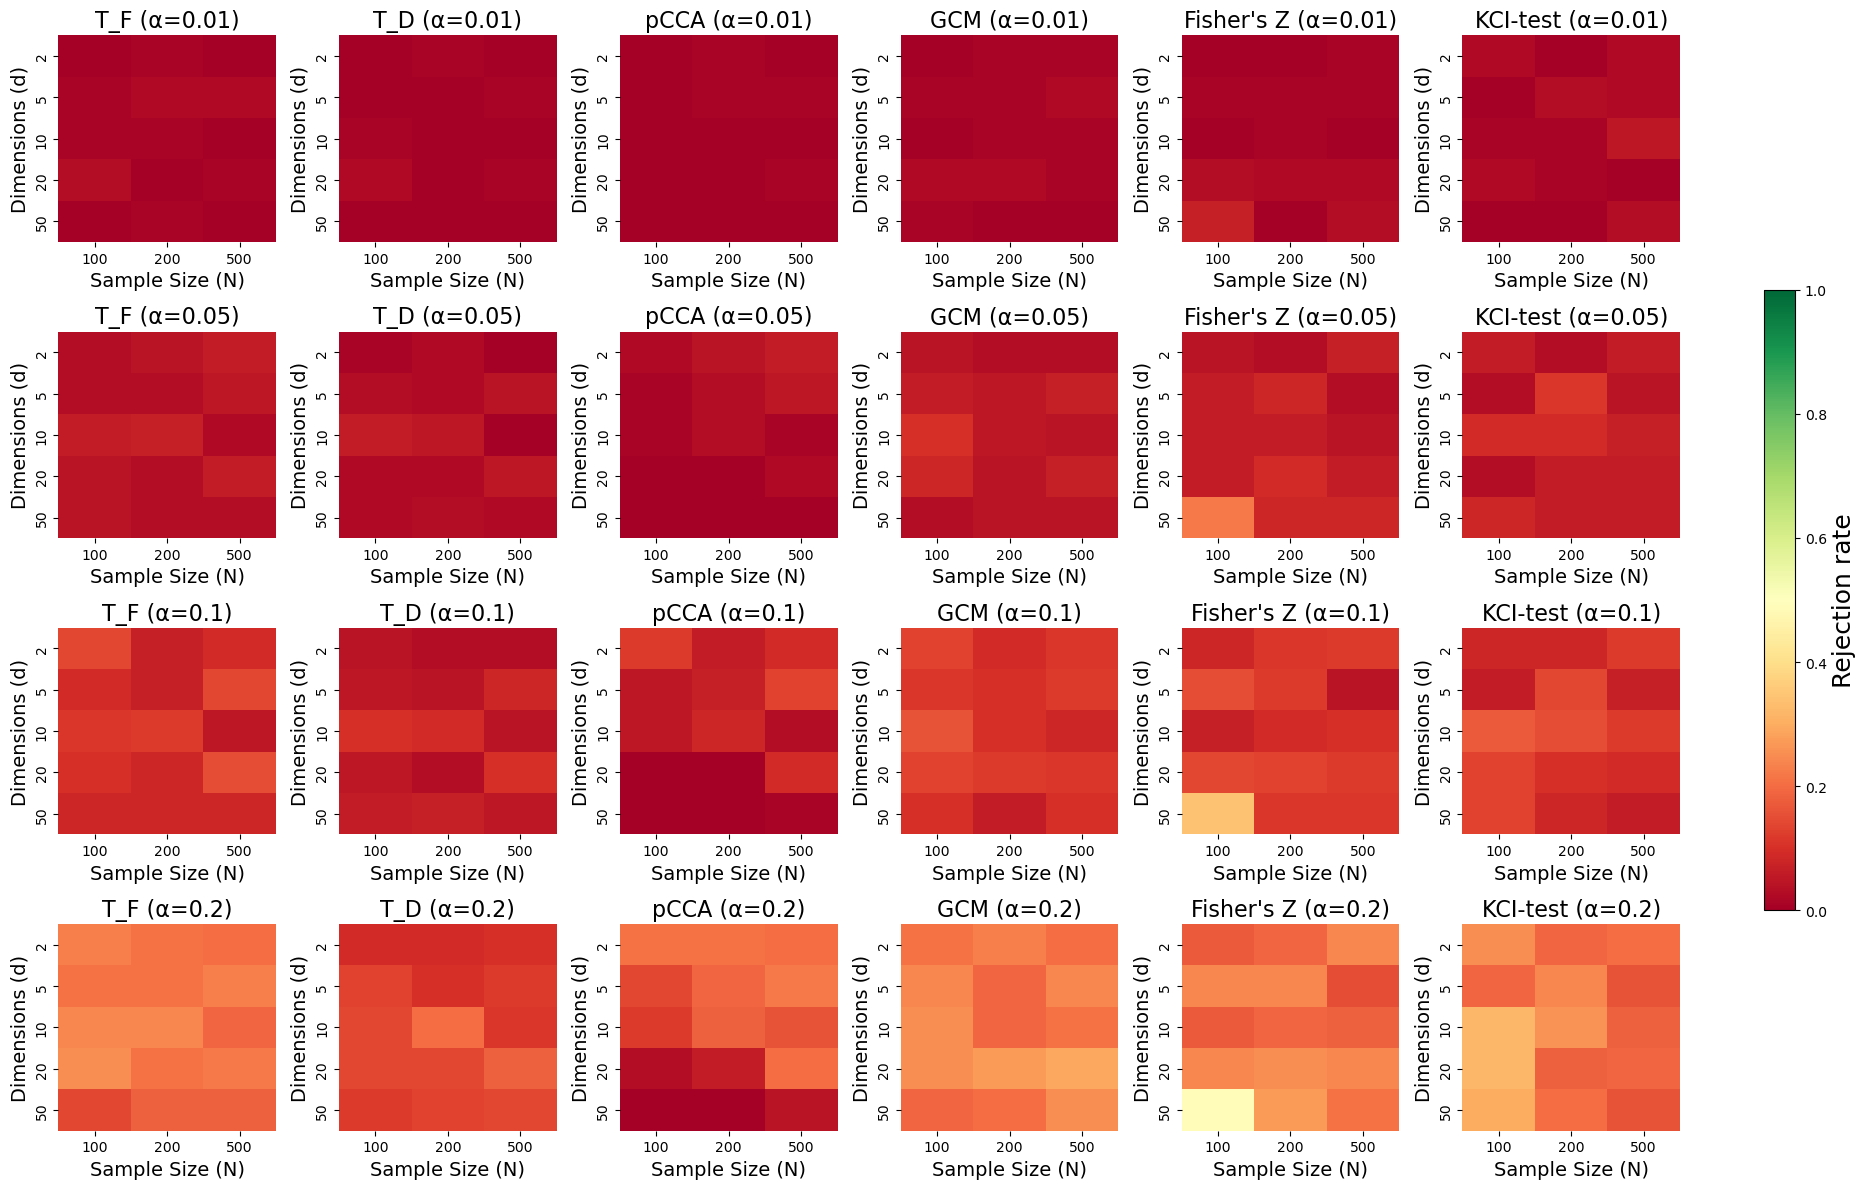

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_heatmap(data, ax, title, vmin, vmax, alpha, std_dev, significance_level=0.05, font_size=14, label_font_size=16):
    # Prepare annotations with stars for significant cells
    annotations = np.empty_like(data, dtype=object)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Calculate Z-score and p-value for the current cell
            z_score = (data[i, j] - alpha) / std_dev
            p_val_z = 1 - norm.cdf(z_score)  # Upper-tail test
            
            # If p-value is below the significance threshold, add a star
            if p_val_z < significance_level:
                annotations[i, j] = f'{data[i, j]:.2f} *'
            else:
                annotations[i, j] = f'{data[i, j]:.2f}'
    
    # Plot the heatmap with the custom annotations
    sns.heatmap(data, fmt="", cmap="RdYlGn", ax=ax, 
                xticklabels=[str(n) for n in samples], 
                yticklabels=[str(d) for d in dimensions],
                cbar=False, vmin=vmin, vmax=vmax,
                annot_kws={"size": font_size})
    
    ax.set_title(title, fontsize=label_font_size+2)
    ax.set_xlabel('Sample Size (N)', fontsize=label_font_size)
    ax.set_ylabel('Dimensions (d)', fontsize=label_font_size)

# Different alpha values
alphas = [0.01, 0.05, 0.1, 0.2]
std_dev = 0.01  # Assuming Gaussian standard deviation for simplicity

# Set up the 4x4 grid of subplots
fig, axes = plt.subplots(len(alphas), 6, figsize=(20, 12))

# Loop through each alpha and create corresponding row of heatmaps
for row, alpha in enumerate(alphas):
    mean_pvals = {
        'T_F': (np.array(results_H1['T_F-pval']) < alpha).mean(axis=2)[:, :, 0],
        'T_D': (np.array(results_H1['T_D-pval']) < alpha).mean(axis=2)[:, :, 0],
        'pCCA': (np.array(results_H1['CCA-pval']) < alpha).mean(axis=2)[:, :, 0],
        # 'T_D': (np.array(results_H1['OD-pval']) < alpha).mean(axis=2)[:, :, 0],
        'GCM': (np.array(results_H1['GCM-pval']) < alpha).mean(axis=2)[:, :, 0],
        'Fisher\'s Z': (np.array(results_H1['F-pval']) < alpha).mean(axis=2)[:, :, 0],
        'KCI-test': (np.array(results_H1['KCI-pval']) < alpha).mean(axis=2)[:, :, 0]
    }

    # Find common vmin and vmax for all heatmaps at this alpha
    vmin = 0
    vmax = 1
    # Create heatmaps for each method (GEV, GCM, F-test, KCI-test)
    for col, (method, data) in enumerate(mean_pvals.items()):
        plot_heatmap(data, axes[row, col], f'{method} (α={alpha})', vmin, vmax, alpha, std_dev, font_size=12, label_font_size=14)

# Create a single color bar on the right side of the heatmaps
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm), ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Rejection rate', fontsize=18)  # Set larger font for the colorbar label

# Adjust layout to create space for the color bar
plt.subplots_adjust(right=0.85)  # Adjust right space for the color bar
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Fine-tune layout to fit everything

plt.show()


/tmp/ipykernel_5143/1088992567.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


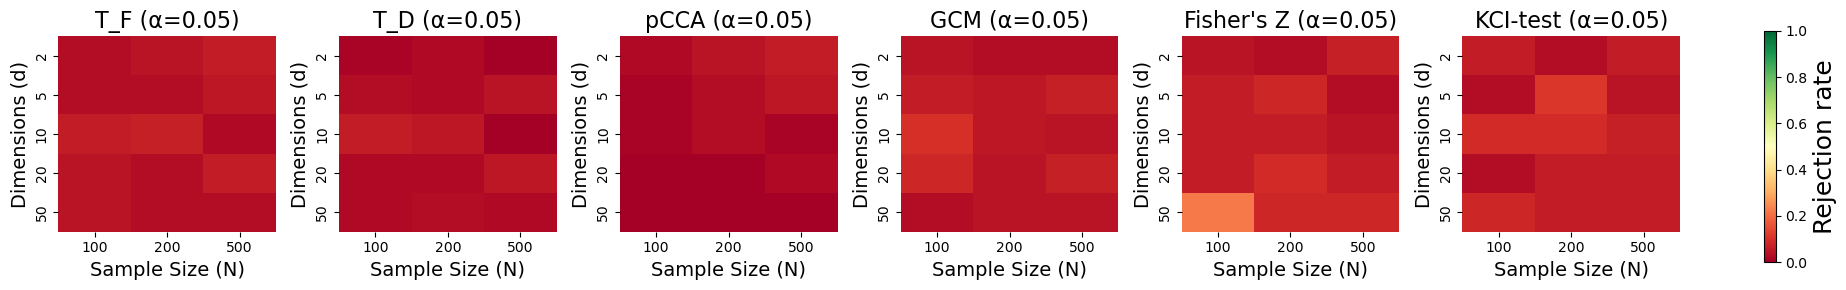

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_heatmap(data, ax, title, vmin, vmax, alpha, std_dev, significance_level=0.05, font_size=14, label_font_size=16):
    # Prepare annotations with stars for significant cells
    annotations = np.empty_like(data, dtype=object)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # Calculate Z-score and p-value for the current cell
            z_score = (data[i, j] - alpha) / std_dev
            p_val_z = 1 - norm.cdf(z_score)  # Upper-tail test
            
            # If p-value is below the significance threshold, add a star
            if p_val_z < significance_level:
                annotations[i, j] = f'{data[i, j]:.2f} *'
            else:
                annotations[i, j] = f'{data[i, j]:.2f}'
    
    # Plot the heatmap with the custom annotations
    sns.heatmap(data, fmt="", cmap="RdYlGn", ax=ax, 
                xticklabels=[str(n) for n in samples], 
                yticklabels=[str(d) for d in dimensions],
                cbar=False, vmin=vmin, vmax=vmax,
                annot_kws={"size": font_size})
    
    ax.set_title(title, fontsize=label_font_size+2)
    ax.set_xlabel('Sample Size (N)', fontsize=label_font_size)
    ax.set_ylabel('Dimensions (d)', fontsize=label_font_size)

# Set alpha to 0.05 and standard deviation for Gaussian assumption
alpha = 0.05
std_dev = 0.01

# Create the figure with a single row for the heatmaps
fig, axes = plt.subplots(1, 6, figsize=(20, 3))

# Extract the mean p-values for alpha = 0.05 for each method
mean_pvals = {
    'T_F': (np.array(results_H1['T_F-pval']) < alpha).mean(axis=2)[:, :, 0],
    'T_D': (np.array(results_H1['T_D-pval']) < alpha).mean(axis=2)[:, :, 0],
    'pCCA': (np.array(results_H1['CCA-pval']) < alpha).mean(axis=2)[:, :, 0],
    'GCM': (np.array(results_H1['GCM-pval']) < alpha).mean(axis=2)[:, :, 0],
    'Fisher\'s Z': (np.array(results_H1['F-pval']) < alpha).mean(axis=2)[:, :, 0],
    'KCI-test': (np.array(results_H1['KCI-pval']) < alpha).mean(axis=2)[:, :, 0]
}

# Set the common vmin and vmax for the color scaling
vmin = 0
vmax = 1

# Plot heatmaps for each method
for col, (method, data) in enumerate(mean_pvals.items()):
    plot_heatmap(data, axes[col], f'{method} (α={alpha})', vmin, vmax, alpha, std_dev, font_size=12, label_font_size=14)

# Create a color bar for the heatmaps
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm), ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Rejection rate', fontsize=18)

# Adjust layout
plt.subplots_adjust(right=0.85)  # Adjust right space for the color bar
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Fine-tune layout to fit everything

plt.show()


(array([0.00177863, 0.        , 0.00177863, 0.00533588, 0.00177863,
        0.0071145 , 0.0071145 , 0.02134351, 0.01422901, 0.02845802,
        0.02312214, 0.04268702, 0.08537405, 0.06580916, 0.07825954,
        0.07825954, 0.07648092, 0.12628245, 0.09070993, 0.12806107,
        0.09426718, 0.10493893, 0.11027481, 0.08359542, 0.09960306,
        0.06936641, 0.04268702, 0.05335878, 0.04268702, 0.0480229 ,
        0.02134351, 0.01956489, 0.01600763, 0.02312214, 0.01778626,
        0.0071145 , 0.01422901, 0.00355725, 0.00889313, 0.00177863,
        0.0071145 , 0.00177863, 0.        , 0.        , 0.        ,
        0.00177863, 0.        , 0.        , 0.        , 0.00177863]),
 array([14.20423155, 14.76646329, 15.32869504, 15.89092678, 16.45315853,
        17.01539027, 17.57762202, 18.13985376, 18.70208551, 19.26431725,
        19.826549  , 20.38878074, 20.95101249, 21.51324423, 22.07547597,
        22.63770772, 23.19993946, 23.76217121, 24.32440295, 24.8866347 ,
        25.44886644, 26.01

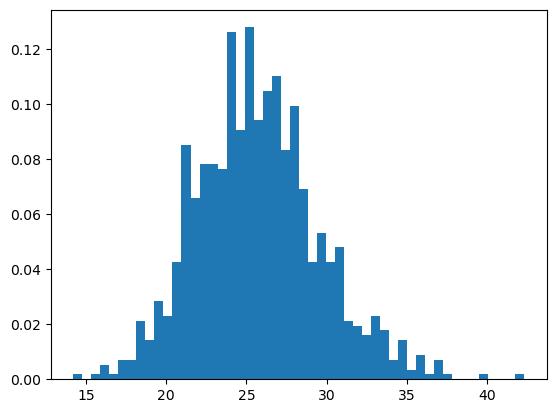

In [11]:
algo = 'T_F'
N, d, p, r = 500, 10, 1, 5
a, b, c = 0.1, 0.1, 0.8
Fs = []
for i in range(1000):
    A_x, A_z, beta, gamma = parameters(r, p, q, d, False)
    X_train, Y_train, Z_train, Y_x_train = generate_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=10, a=a, b=b, c=c)
    dea = DirectEffectAnalysis(type=algo, alpha=1e-5)
    dea.fit(X_train, Y_train, Z_train)
    # F =  np.abs(dea.u[0])
    df1 = d
    df2 = N - p - d - 1
    # dea = DirectEffectAnalysis(type='T_F', alpha=1e-5)
    # dea.fit(X_train, Y_train, Z_train)
    F = np.abs((df2 / df1) * dea.u[0])
    Fs.append(F)
plt.hist(Fs, bins=50, density=True)